# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [14]:
import graphlab
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
sales = graphlab.SFrame('../week2/data/kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [4]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

PROGRESS: Linear regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 21613
PROGRESS: Number of features          : 17
PROGRESS: Number of unpacked features : 17
PROGRESS: Number of coefficients    : 18
PROGRESS: Starting Accelerated Gradient (FISTA)
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |
PROGRESS: +-----------+----------+-----------+--------------+--------------------+---------------+
PROGRESS: Tuning step size. First iteration could take longer than subsequent iterations.
PROGRESS: | 1         | 2        | 0.000002  | 1.716284     | 6962915.603493     | 426631.749026 |
PROGRESS: | 2         | 3        | 0.000002  | 1.761399     | 6843144.200219     | 392488.929838 |
PROGRESS: | 3         | 4      

Find what features had non-zero weight.

In [7]:
model_all.coefficients

name,index,value
(intercept),None,274873.05595
bedrooms,None,0.0
bedrooms_square,None,0.0
bathrooms,None,8468.53108691
sqft_living,None,24.4207209824
sqft_living_sqrt,None,350.060553386
sqft_lot,None,0.0
sqft_lot_sqrt,None,0.0
floors,None,0.0
floors_square,None,0.0


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [8]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [20]:
import numpy as np

RSS_list = []
for l1_penalty in np.logspace(1, 7, num=13):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,
                                              verbose = False,
                                              l2_penalty=0., l1_penalty=l1_penalty)
    y_pred = model.predict(validation)
    RSS = sum((validation['price'] - y_pred)**2)
    RSS_list.append(RSS)
    print "l1: {},  RSS: {}".format(l1_penalty, RSS)

l1: 10.0,  RSS: 6.25766285142e+14
l1: 31.6227766017,  RSS: 6.25766285362e+14
l1: 100.0,  RSS: 6.25766286058e+14
l1: 316.227766017,  RSS: 6.25766288257e+14
l1: 1000.0,  RSS: 6.25766295212e+14
l1: 3162.27766017,  RSS: 6.25766317206e+14
l1: 10000.0,  RSS: 6.25766386761e+14
l1: 31622.7766017,  RSS: 6.25766606749e+14
l1: 100000.0,  RSS: 6.25767302792e+14
l1: 316227.766017,  RSS: 6.25769507644e+14
l1: 1000000.0,  RSS: 6.25776517727e+14
l1: 3162277.66017,  RSS: 6.25799062845e+14
l1: 10000000.0,  RSS: 6.25883719085e+14


6.25766285142e+14


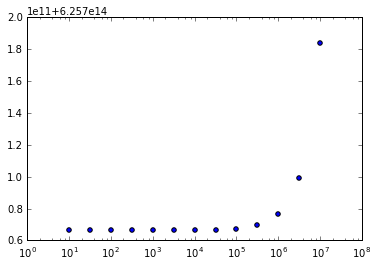

In [21]:
print min(RSS_list)
plt.xscale('log')
plt.scatter(np.logspace(1, 7, num=13), RSS_list)

*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [43]:
# l1: 10.0
model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,
                                              verbose = False,
                                              l2_penalty=0., l1_penalty=10.)
y_pred = model.predict(testing)
RSS = sum((testing['price'] - y_pred)**2)
print RSS

1.56983602382e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [44]:
model.coefficients

name,index,value
(intercept),None,18993.4272128
bedrooms,None,7936.96767903
bedrooms_square,None,936.993368193
bathrooms,None,25409.5889341
sqft_living,None,39.1151363797
sqft_living_sqrt,None,1124.65021281
sqft_lot,None,0.00348361822299
sqft_lot_sqrt,None,148.258391011
floors,None,21204.335467
floors_square,None,12915.5243361


# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [45]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [46]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [50]:
n_zeros_list = []
for l1_penalty in np.logspace(8, 10, num=20):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,
                                              verbose = False,
                                              l2_penalty=0., l1_penalty=l1_penalty)
    n_zeros = model['coefficients']['value'].nnz()
    n_zeros_list.append(n_zeros)
    print "l1: {},  num_zeroes: {}".format(l1_penalty, n_zeros)

#n_zeros_list

l1: 100000000.0,  num_zeroes: 18
l1: 127427498.57,  num_zeroes: 18
l1: 162377673.919,  num_zeroes: 18
l1: 206913808.111,  num_zeroes: 18
l1: 263665089.873,  num_zeroes: 17
l1: 335981828.628,  num_zeroes: 17
l1: 428133239.872,  num_zeroes: 17
l1: 545559478.117,  num_zeroes: 17
l1: 695192796.178,  num_zeroes: 17
l1: 885866790.41,  num_zeroes: 16
l1: 1128837891.68,  num_zeroes: 15
l1: 1438449888.29,  num_zeroes: 15
l1: 1832980710.83,  num_zeroes: 13
l1: 2335721469.09,  num_zeroes: 12
l1: 2976351441.63,  num_zeroes: 10
l1: 3792690190.73,  num_zeroes: 6
l1: 4832930238.57,  num_zeroes: 5
l1: 6158482110.66,  num_zeroes: 3
l1: 7847599703.51,  num_zeroes: 1
l1: 10000000000.0,  num_zeroes: 1


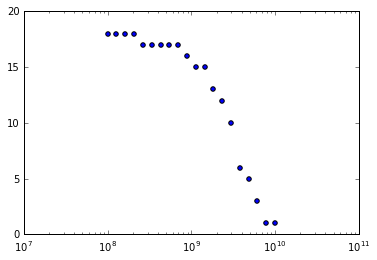

In [52]:
plt.xscale('log')
plt.scatter(np.logspace(8, 10, num=20), n_zeros_list)

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [ ]:
l1_penalty_min = 
l1_penalty_max = 

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [ ]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?